<a href="https://colab.research.google.com/github/Sedkameni/IntroAI_Willis/blob/main/Sedrick_assignment10_IAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 22.7 MB/s eta 0:00:00


In [3]:
"""
IMDB Sentiment Analysis: Traditional ML & BERT Implementation
Dataset: IMDB Movie Reviews (50,000 reviews)
Author: Sedrick
Date: November 2025

This notebook demonstrates:
- Comprehensive text preprocessing
- Feature engineering (BoW, TF-IDF, Word Embeddings)
- Traditional ML models (Logistic Regression, SVM)
- BERT fine-tuning for sentiment analysis
- Model evaluation and comparison
"""

# ============================================================================
# 1. IMPORT LIBRARIES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from collections import Counter

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import spacy

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
)

# Deep Learning (BERT)
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification
)
from datasets import Dataset
import torch

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


Saving IMDB Dataset.csv.zip to IMDB Dataset.csv (1).zip

DATASET LOADING & EXPLORATION

Dataset Shape: (50000, 2)
Number of Reviews: 50000

First 5 rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Missing Values:
review       0
sentiment    0
dtype: int64

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name

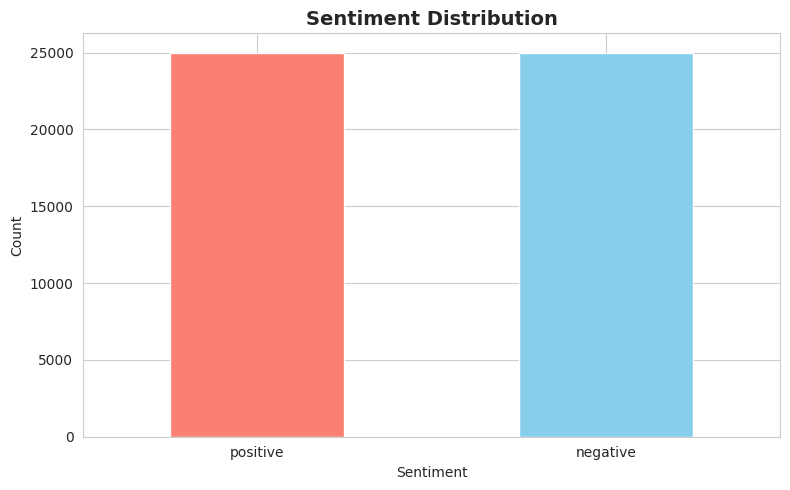


Review Length Statistics:
       review_length    word_count
count   50000.000000  50000.000000
mean     1309.431020    231.156940
std       989.728014    171.343997
min        32.000000      4.000000
25%       699.000000    126.000000
50%       970.000000    173.000000
75%      1590.250000    280.000000
max     13704.000000   2470.000000


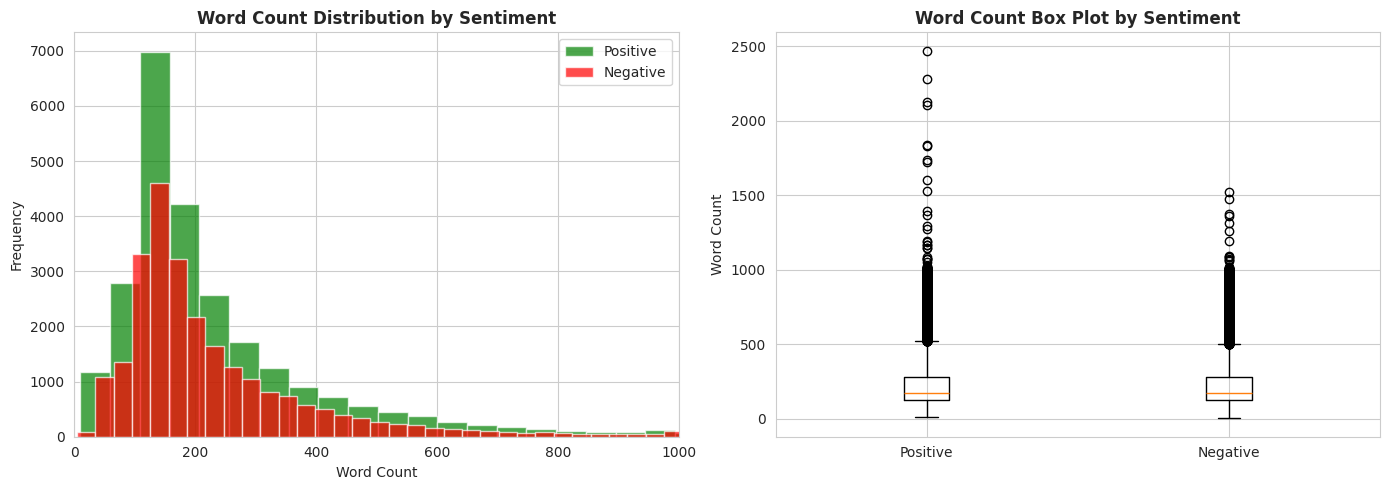

In [4]:
# ============================================================================
# 2. LOAD AND EXPLORE DATASET
# ============================================================================
from google.colab import files
uploaded = files.upload()

import zipfile

# Replace with your uploaded filename
zip_path = "IMDB Dataset.csv.zip"

# Extract the contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")

# Find out what files were extracted
import os
os.listdir(".")

print("\n" + "="*80)
print("DATASET LOADING & EXPLORATION")
print("="*80)

# Load dataset
df = pd.read_csv("IMDB Dataset.csv")

print(f"\nDataset Shape: {df.shape}")
print(f"Number of Reviews: {len(df)}")
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Information:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

# Visualize sentiment distribution
plt.figure(figsize=(8, 5))
df['sentiment'].value_counts().plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Sentiment Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Review length statistics
df['review_length'] = df['review'].apply(len)
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))

print("\nReview Length Statistics:")
print(df[['review_length', 'word_count']].describe())

# Visualize review lengths by sentiment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df[df['sentiment']=='positive']['word_count'], bins=50, alpha=0.7, label='Positive', color='green')
axes[0].hist(df[df['sentiment']=='negative']['word_count'], bins=50, alpha=0.7, label='Negative', color='red')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Word Count Distribution by Sentiment', fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, 1000)

axes[1].boxplot([df[df['sentiment']=='positive']['word_count'],
                 df[df['sentiment']=='negative']['word_count']],
                labels=['Positive', 'Negative'])
axes[1].set_ylabel('Word Count')
axes[1].set_title('Word Count Box Plot by Sentiment', fontweight='bold')

plt.tight_layout()
plt.show()

In [5]:
# ============================================================================
# 3. DATA PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

# Check for missing values
print(f"\nMissing values before handling: {df.isnull().sum().sum()}")
df = df.dropna()
print(f"Missing values after handling: {df.isnull().sum().sum()}")

# Encode labels
print("\nEncoding sentiment labels")
df['sentiment_encoded'] = df['sentiment'].map({'positive': 1, 'negative': 0})
print("Label encoding complete: positive=1, negative=0")

# Text cleaning function
def clean_text(text):
    """
    Comprehensive text cleaning:
    - Remove HTML tags
    - Remove URLs
    - Remove special characters
    - Convert to lowercase
    - Remove extra whitespace
    """
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove special characters and digits (keep letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

print("\nCleaning text data...")
df['review_cleaned'] = df['review'].apply(clean_text)

print("\nExample of cleaned text:")
print(f"Original: {df['review'].iloc[0][:200]}...")
print(f"Cleaned: {df['review_cleaned'].iloc[0][:200]}...")

# Advanced preprocessing with lemmatization and stopword removal
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Download punkt_tab resource
nltk.download('punkt_tab', quiet=True)


def preprocess_text(text):
    """
    Advanced preprocessing:
    - Tokenization
    - Stopword removal
    - Lemmatization
    """
    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens
              if token not in stop_words and len(token) > 2]

    return ' '.join(tokens)

print("\nApplying advanced preprocessing (this may take a few minutes)...")
# For demo purposes, process subset (full dataset takes time)
df_sample = df.sample(n=5000, random_state=42)  # Use full df for production
df_sample['review_processed'] = df_sample['review_cleaned'].apply(preprocess_text)

print("\nExample of processed text:")
print(f"Cleaned: {df_sample['review_cleaned'].iloc[0][:150]}...")
print(f"Processed: {df_sample['review_processed'].iloc[0][:150]}...")

# For full implementation, use entire dataset
df['review_processed'] = df['review_cleaned'].apply(preprocess_text)

print("\n Preprocessing complete!")


DATA PREPROCESSING

Missing values before handling: 0
Missing values after handling: 0

Encoding sentiment labels
Label encoding complete: positive=1, negative=0

Cleaning text data...

Example of cleaned text:
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...
Cleaned: one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brut...

Applying advanced preprocessing (this may take a few minutes)...

Example of processed text:
Cleaned: i really liked this summerslam due to the look of the arena the curtains and just the look overall was interesting to me for some reason anyways this ...
Processed: really liked summerslam due look arena curtain look overall interesting reason anyways could 


FEATURE ENGINEERING

Training set size: 40000
Test set size: 10000
Class distribution in training: sentiment_encoded
1    20000
0    20000
Name: count, dtype: int64

--- BAG OF WORDS (BoW) ---
BoW training shape: (40000, 5000)
BoW test shape: (10000, 5000)
Vocabulary size: 5000

Top 20 words in BoW:
  movie: 79298
  film: 72181
  one: 42262
  like: 31673
  time: 23538
  good: 22918
  character: 22155
  get: 19474
  even: 19366
  story: 19351


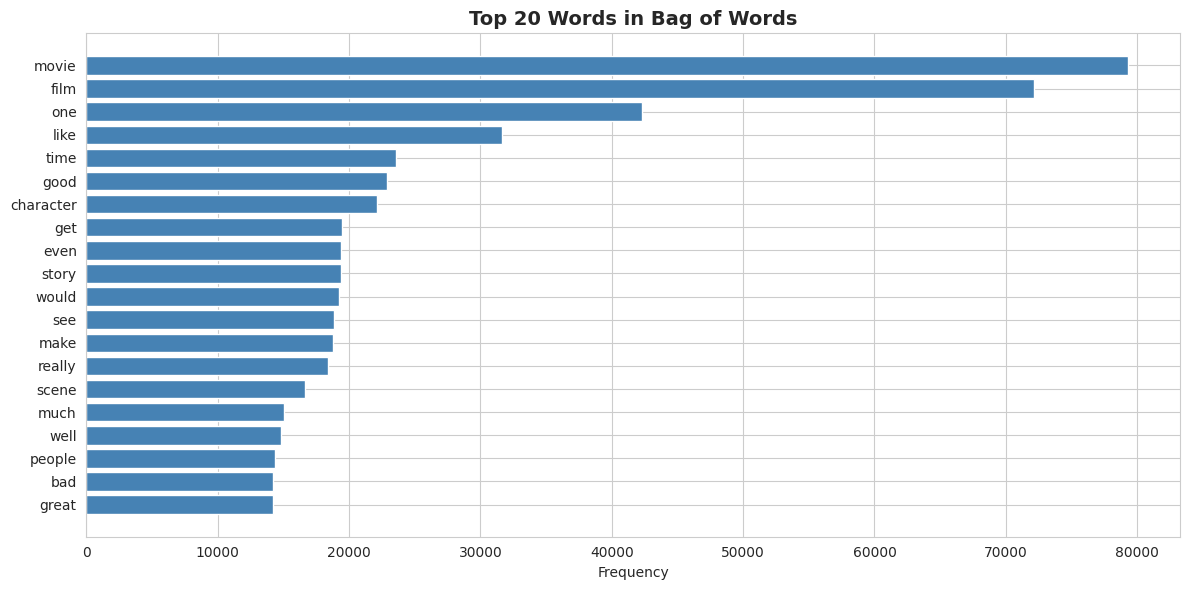


--- TF-IDF (Term Frequency - Inverse Document Frequency) ---
TF-IDF training shape: (40000, 5000)
TF-IDF test shape: (10000, 5000)

Top 20 words by TF-IDF score:
  movie: 1698.80
  film: 1498.28
  one: 1147.17
  like: 1003.68
  good: 889.10
  time: 864.97
  character: 812.36
  story: 789.31
  see: 781.97
  really: 768.27


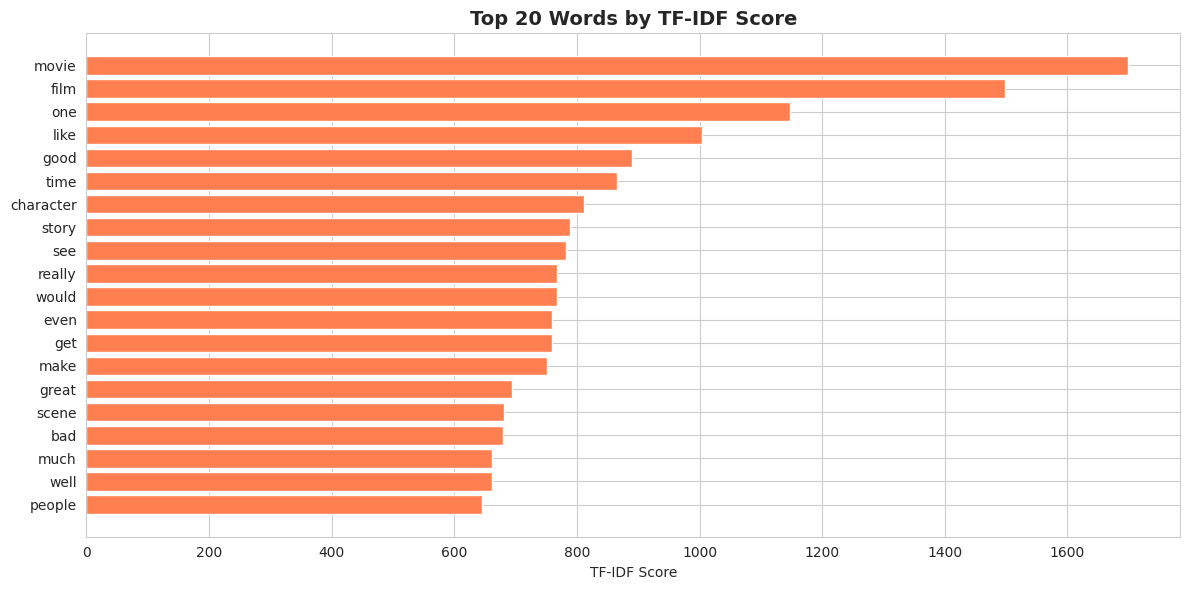


--- WORD EMBEDDINGS (Word2Vec) ---
Training Word2Vec model...
Word2Vec vocabulary size: 34378
Embedding dimension: 100

Words most similar to 'good':
  decent: 0.806
  great: 0.788
  goodand: 0.768
  moviemost: 0.767
  goodoverall: 0.766
  hehe: 0.765
  greatthe: 0.760
  appleby: 0.760
  goodthe: 0.754
  bclass: 0.752

Creating document embeddings...
Word2Vec training shape: (40000, 100)
Word2Vec test shape: (10000, 100)

--- VISUALIZING WORD EMBEDDINGS ---

Visualizing 20 word embeddings...
Applying t-SNE dimensionality reduction...


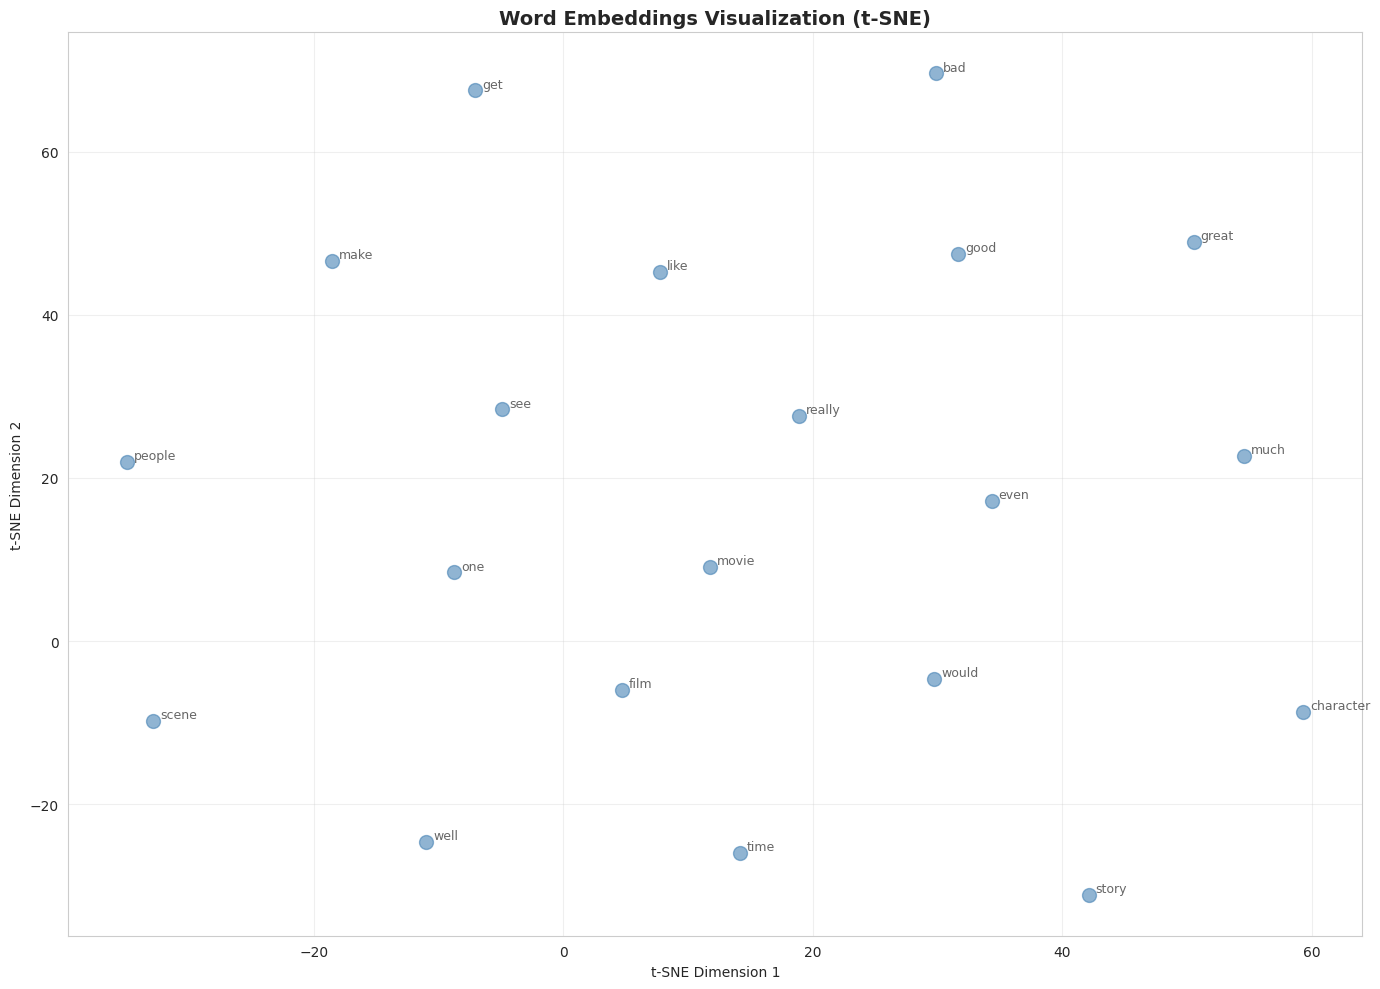

Applying PCA dimensionality reduction...


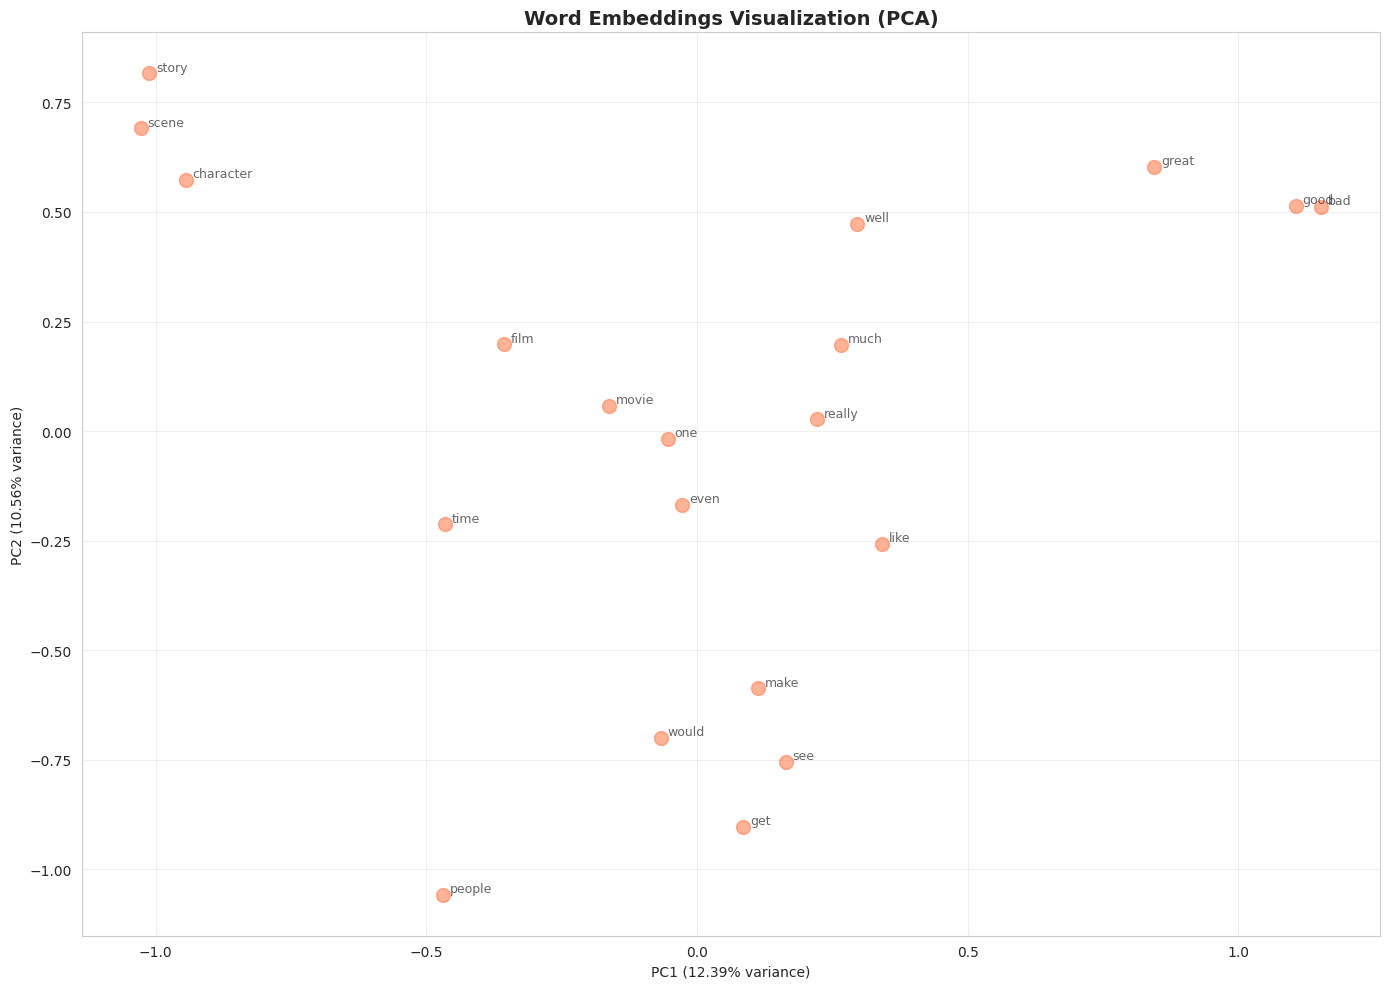


 Feature engineering complete!


In [6]:
# ============================================================================
# 4. FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Split dataset FIRST (to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    df['review_processed'],
    df['sentiment_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment_encoded']
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Class distribution in training: {y_train.value_counts()}")

# -----------------------------
# 4.1 BAG OF WORDS (BoW)
# -----------------------------

print("\n--- BAG OF WORDS (BoW) ---")

bow_vectorizer = CountVectorizer(
    max_features=5000,  # Limit vocabulary size
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=5  # Ignore terms appearing in < 5 documents
)

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print(f"BoW training shape: {X_train_bow.shape}")
print(f"BoW test shape: {X_test_bow.shape}")
print(f"Vocabulary size: {len(bow_vectorizer.vocabulary_)}")

# Most common words
bow_freq = X_train_bow.sum(axis=0).A1
bow_words = bow_vectorizer.get_feature_names_out()
top_words_bow = sorted(zip(bow_words, bow_freq), key=lambda x: x[1], reverse=True)[:20]

print("\nTop 20 words in BoW:")
for word, freq in top_words_bow[:10]:
    print(f"  {word}: {freq}")

# Visualize top words
plt.figure(figsize=(12, 6))
words, freqs = zip(*top_words_bow)
plt.barh(words, freqs, color='steelblue')
plt.xlabel('Frequency')
plt.title('Top 20 Words in Bag of Words', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# -----------------------------
# 4.2 TF-IDF
# -----------------------------

print("\n--- TF-IDF (Term Frequency - Inverse Document Frequency) ---")

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,  # Ignore terms appearing in > 80% of documents
    sublinear_tf=True  # Apply sublinear tf scaling
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF training shape: {X_train_tfidf.shape}")
print(f"TF-IDF test shape: {X_test_tfidf.shape}")

# Top TF-IDF features
tfidf_scores = X_train_tfidf.sum(axis=0).A1
tfidf_words = tfidf_vectorizer.get_feature_names_out()
top_words_tfidf = sorted(zip(tfidf_words, tfidf_scores), key=lambda x: x[1], reverse=True)[:20]

print("\nTop 20 words by TF-IDF score:")
for word, score in top_words_tfidf[:10]:
    print(f"  {word}: {score:.2f}")

# Visualize top TF-IDF words
plt.figure(figsize=(12, 6))
words, scores = zip(*top_words_tfidf)
plt.barh(words, scores, color='coral')
plt.xlabel('TF-IDF Score')
plt.title('Top 20 Words by TF-IDF Score', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# -----------------------------
# 4.3 WORD EMBEDDINGS (Word2Vec)
# -----------------------------

print("\n--- WORD EMBEDDINGS (Word2Vec) ---")

# Tokenize for Word2Vec
print("Training Word2Vec model...")
sentences = [text.split() for text in X_train]

# Train Word2Vec
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,  # Embedding dimension
    window=5,  # Context window
    min_count=5,  # Ignore words with frequency < 5
    workers=4,
    sg=1  # Skip-gram (1) vs CBOW (0)
)

print(f"Word2Vec vocabulary size: {len(w2v_model.wv)}")
print(f"Embedding dimension: {w2v_model.vector_size}")

# Example: Similar words
print("\nWords most similar to 'good':")
try:
    similar_words = w2v_model.wv.most_similar('good', topn=10)
    for word, score in similar_words:
        print(f"  {word}: {score:.3f}")
except KeyError:
    print("  'good' not in vocabulary")

# Document embeddings (average word vectors)
def document_vector(text, model):
    """Average word vectors for document representation"""
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

print("\nCreating document embeddings...")
X_train_w2v = np.array([document_vector(text, w2v_model) for text in X_train])
X_test_w2v = np.array([document_vector(text, w2v_model) for text in X_test])

print(f"Word2Vec training shape: {X_train_w2v.shape}")
print(f"Word2Vec test shape: {X_test_w2v.shape}")

# -----------------------------
# 4.4 VISUALIZE WORD EMBEDDINGS
# -----------------------------

print("\n--- VISUALIZING WORD EMBEDDINGS ---")

# Select common words for visualization
common_words = [word for word, freq in top_words_bow[:100] if word in w2v_model.wv][:50]
word_vectors = np.array([w2v_model.wv[word] for word in common_words])

print(f"\nVisualizing {len(common_words)} word embeddings...")

# t-SNE for 2D visualization
print("Applying t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=15, n_iter=1000)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(14, 10))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.6, s=100, c='steelblue')

for i, word in enumerate(common_words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]),
                xytext=(5, 2), textcoords='offset points', fontsize=9, alpha=0.7)

plt.title('Word Embeddings Visualization (t-SNE)', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# PCA visualization
print("Applying PCA dimensionality reduction...")
pca = PCA(n_components=2, random_state=42)
word_vectors_pca = pca.fit_transform(word_vectors)

plt.figure(figsize=(14, 10))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], alpha=0.6, s=100, c='coral')

for i, word in enumerate(common_words):
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]),
                xytext=(5, 2), textcoords='offset points', fontsize=9, alpha=0.7)

plt.title('Word Embeddings Visualization (PCA)', fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Feature engineering complete!")

In [7]:
# ============================================================================
# 5. TRADITIONAL ML MODELS
# ============================================================================

print("\n" + "="*80)
print("TRADITIONAL MACHINE LEARNING MODELS")
print("="*80)

# Store results
results = {}

# -----------------------------
# 5.1 LOGISTIC REGRESSION
# -----------------------------

print("\n--- LOGISTIC REGRESSION ---")

# Train on TF-IDF features
print("\nTraining Logistic Regression on TF-IDF features...")

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C=1.0,
    solver='liblinear'
)

lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
y_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

# Evaluation
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

results['Logistic Regression'] = {
    'accuracy': acc_lr,
    'precision': prec_lr,
    'recall': rec_lr,
    'f1': f1_lr,
    'roc_auc': roc_auc_lr,
    'predictions': y_pred_lr,
    'probabilities': y_proba_lr
}

print(f"\nLogistic Regression Results:")
print(f"  Accuracy:  {acc_lr:.4f}")
print(f"  Precision: {prec_lr:.4f}")
print(f"  Recall:    {rec_lr:.4f}")
print(f"  F1-Score:  {f1_lr:.4f}")
print(f"  ROC-AUC:   {roc_auc_lr:.4f}")

# Grid Search for hyperparameter tuning
print("\nPerforming Grid Search for Logistic Regression...")

param_grid_lr = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

grid_lr.fit(X_train_tfidf, y_train)

print(f"Best parameters: {grid_lr.best_params_}")
print(f"Best F1-score (CV): {grid_lr.best_score_:.4f}")

# Evaluate best model
y_pred_lr_best = grid_lr.predict(X_test_tfidf)
y_proba_lr_best = grid_lr.predict_proba(X_test_tfidf)[:, 1]

print(f"\nOptimized Logistic Regression Test F1-Score: {f1_score(y_test, y_pred_lr_best):.4f}")

results['Logistic Regression (Optimized)'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr_best),
    'precision': precision_score(y_test, y_pred_lr_best),
    'recall': recall_score(y_test, y_pred_lr_best),
    'f1': f1_score(y_test, y_pred_lr_best),
    'roc_auc': roc_auc_score(y_test, y_proba_lr_best),
    'predictions': y_pred_lr_best,
    'probabilities': y_proba_lr_best
}

# -----------------------------
# 5.2 SUPPORT VECTOR MACHINE (SVM)
# -----------------------------

print("\n--- SUPPORT VECTOR MACHINE (Linear SVC) ---")

print("\nTraining Linear SVM on TF-IDF features...")

svm_model = LinearSVC(
    C=1.0,
    max_iter=1000,
    random_state=42
)

svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

# LinearSVC doesn't have predict_proba, use decision_function
y_scores_svm = svm_model.decision_function(X_test_tfidf)

# Evaluation
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm)
rec_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_scores_svm)

results['SVM'] = {
    'accuracy': acc_svm,
    'precision': prec_svm,
    'recall': rec_svm,
    'f1': f1_svm,
    'roc_auc': roc_auc_svm,
    'predictions': y_pred_svm,
    'probabilities': y_scores_svm
}

print(f"\nSVM Results:")
print(f"  Accuracy:  {acc_svm:.4f}")
print(f"  Precision: {prec_svm:.4f}")
print(f"  Recall:    {rec_svm:.4f}")
print(f"  F1-Score:  {f1_svm:.4f}")
print(f"  ROC-AUC:   {roc_auc_svm:.4f}")

# Grid Search for SVM
print("\nPerforming Grid Search for SVM...")

param_grid_svm = {
    'C': [0.1, 1.0, 10.0],
    'loss': ['hinge', 'squared_hinge']
}

grid_svm = GridSearchCV(
    LinearSVC(max_iter=1000, random_state=42),
    param_grid_svm,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

grid_svm.fit(X_train_tfidf, y_train)

print(f"Best parameters: {grid_svm.best_params_}")
print(f"Best F1-score (CV): {grid_svm.best_score_:.4f}")

y_pred_svm_best = grid_svm.predict(X_test_tfidf)
y_scores_svm_best = grid_svm.decision_function(X_test_tfidf)

print(f"\nOptimized SVM Test F1-Score: {f1_score(y_test, y_pred_svm_best):.4f}")

results['SVM (Optimized)'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm_best),
    'precision': precision_score(y_test, y_pred_svm_best),
    'recall': recall_score(y_test, y_pred_svm_best),
    'f1': f1_score(y_test, y_pred_svm_best),
    'roc_auc': roc_auc_score(y_test, y_scores_svm_best),
    'predictions': y_pred_svm_best,
    'probabilities': y_scores_svm_best
}

# -----------------------------
# 5.3 NAIVE BAYES (BONUS)
# -----------------------------

print("\n--- NAIVE BAYES (Bonus Model) ---")

nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
y_proba_nb = nb_model.predict_proba(X_test_tfidf)[:, 1]

results['Naive Bayes'] = {
    'accuracy': accuracy_score(y_test, y_pred_nb),
    'precision': precision_score(y_test, y_pred_nb),
    'recall': recall_score(y_test, y_pred_nb),
    'f1': f1_score(y_test, y_pred_nb),
    'roc_auc': roc_auc_score(y_test, y_proba_nb),
    'predictions': y_pred_nb,
    'probabilities': y_proba_nb
}

print(f"\nNaive Bayes Results:")
print(f"  Accuracy:  {results['Naive Bayes']['accuracy']:.4f}")
print(f"  F1-Score:  {results['Naive Bayes']['f1']:.4f}")
print(f"  ROC-AUC:   {results['Naive Bayes']['roc_auc']:.4f}")

print("\n Traditional ML models training complete!")


TRADITIONAL MACHINE LEARNING MODELS

--- LOGISTIC REGRESSION ---

Training Logistic Regression on TF-IDF features...

Logistic Regression Results:
  Accuracy:  0.8935
  Precision: 0.8854
  Recall:    0.9040
  F1-Score:  0.8946
  ROC-AUC:   0.9594

Performing Grid Search for Logistic Regression...
Best parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1-score (CV): 0.8865

Optimized Logistic Regression Test F1-Score: 0.8946

--- SUPPORT VECTOR MACHINE (Linear SVC) ---

Training Linear SVM on TF-IDF features...

SVM Results:
  Accuracy:  0.8832
  Precision: 0.8779
  Recall:    0.8902
  F1-Score:  0.8840
  ROC-AUC:   0.9544

Performing Grid Search for SVM...
Best parameters: {'C': 0.1, 'loss': 'squared_hinge'}
Best F1-score (CV): 0.8874

Optimized SVM Test F1-Score: 0.8935

--- NAIVE BAYES (Bonus Model) ---

Naive Bayes Results:
  Accuracy:  0.8614
  F1-Score:  0.8633
  ROC-AUC:   0.9347

 Traditional ML models training complete!


In [8]:
# ============================================================================
# 6. BERT MODEL (FINE-TUNING)
# ============================================================================

print("\n" + "="*80)
print("BERT MODEL - FINE-TUNING")
print("="*80)

# Use smaller subset for BERT fine-tuning (resource-intensive)
# For production, use full dataset
BERT_SAMPLE_SIZE = 5000  # Adjust based on available resources

print(f"\nUsing {BERT_SAMPLE_SIZE} samples for BERT fine-tuning...")

# Sample data
X_train_bert = X_train.sample(n=min(BERT_SAMPLE_SIZE, len(X_train)), random_state=42)
y_train_bert = y_train[X_train_bert.index]

X_test_bert = X_test.sample(n=min(1000, len(X_test)), random_state=42)
y_test_bert = y_test[X_test_bert.index]

# Use original cleaned text (not processed) for BERT
X_train_bert_text = df.loc[X_train_bert.index, 'review_cleaned'].tolist()
X_test_bert_text = df.loc[X_test_bert.index, 'review_cleaned'].tolist()

print(f"BERT training samples: {len(X_train_bert_text)}")
print(f"BERT test samples: {len(X_test_bert_text)}")

# Initialize tokenizer and model
print("\nLoading BERT tokenizer and model...")

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model_bert = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

print(" BERT model loaded successfully!")

# Tokenize data
print("\nTokenizing data...")

def tokenize_function(texts):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=256,  # Limit sequence length
        return_tensors='pt'
    )

train_encodings = tokenizer(
    X_train_bert_text,
    truncation=True,
    padding=True,
    max_length=256
)

test_encodings = tokenizer(
    X_test_bert_text,
    truncation=True,
    padding=True,
    max_length=256
)

# Create Dataset objects
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': y_train_bert.tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': y_test_bert.tolist()
})

print(" Tokenization complete!")

# Training arguments
training_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=2,  # Increase for better performance
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions)
    rec = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }

# Initialize Trainer
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Fine-tune BERT
print("\nFine-tuning BERT model (this will take several minutes)...")
print("NOTE: For demo purposes, using 2 epochs. Increase for production.")

trainer.train()

print("\n BERT fine-tuning complete!")

# Evaluate BERT
print("\nEvaluating BERT model...")
eval_results = trainer.evaluate()

print("\nBERT Evaluation Results:")
for key, value in eval_results.items():
    if not key.startswith('eval_'):
        continue
    metric_name = key.replace('eval_', '')
    print(f"  {metric_name.capitalize()}: {value:.4f}")

# Predictions
predictions = trainer.predict(test_dataset)
y_pred_bert = np.argmax(predictions.predictions, axis=-1)
y_proba_bert = torch.softmax(torch.tensor(predictions.predictions), dim=-1)[:, 1].numpy()

results['BERT'] = {
    'accuracy': accuracy_score(y_test_bert, y_pred_bert),
    'precision': precision_score(y_test_bert, y_pred_bert),
    'recall': recall_score(y_test_bert, y_pred_bert),
    'f1': f1_score(y_test_bert, y_pred_bert),
    'roc_auc': roc_auc_score(y_test_bert, y_proba_bert),
    'predictions': y_pred_bert,
    'probabilities': y_proba_bert
}

print("\n BERT evaluation complete!")


BERT MODEL - FINE-TUNING

Using 5000 samples for BERT fine-tuning...
BERT training samples: 5000
BERT test samples: 1000

Loading BERT tokenizer and model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 BERT model loaded successfully!

Tokenizing data...
 Tokenization complete!

Fine-tuning BERT model (this will take several minutes)...
NOTE: For demo purposes, using 2 epochs. Increase for production.


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sedrick-kameni (sedrick-kameni-willis-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.360700,0.265837,0.900000,0.879852,0.931507,0.904943
2,0.146600,0.379363,0.905000,0.896947,0.919765,0.908213



 BERT fine-tuning complete!

Evaluating BERT model...



BERT Evaluation Results:
  Loss: 0.3794
  Accuracy: 0.9050
  Precision: 0.8969
  Recall: 0.9198
  F1: 0.9082
  Runtime: 14.3817
  Samples_per_second: 69.5330
  Steps_per_second: 8.6920

 BERT evaluation complete!



MODEL COMPARISON & EVALUATION

Model Performance Comparison:
                          Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
            Logistic Regression    0.8935   0.885406 0.904000  0.894607 0.959411
Logistic Regression (Optimized)    0.8935   0.885406 0.904000  0.894607 0.959411
                            SVM    0.8832   0.877909 0.890200  0.884012 0.954428
                SVM (Optimized)    0.8924   0.884254 0.903000  0.893529 0.959377
                    Naive Bayes    0.8614   0.851693 0.875200  0.863287 0.934669
                           BERT    0.9050   0.896947 0.919765  0.908213 0.966924


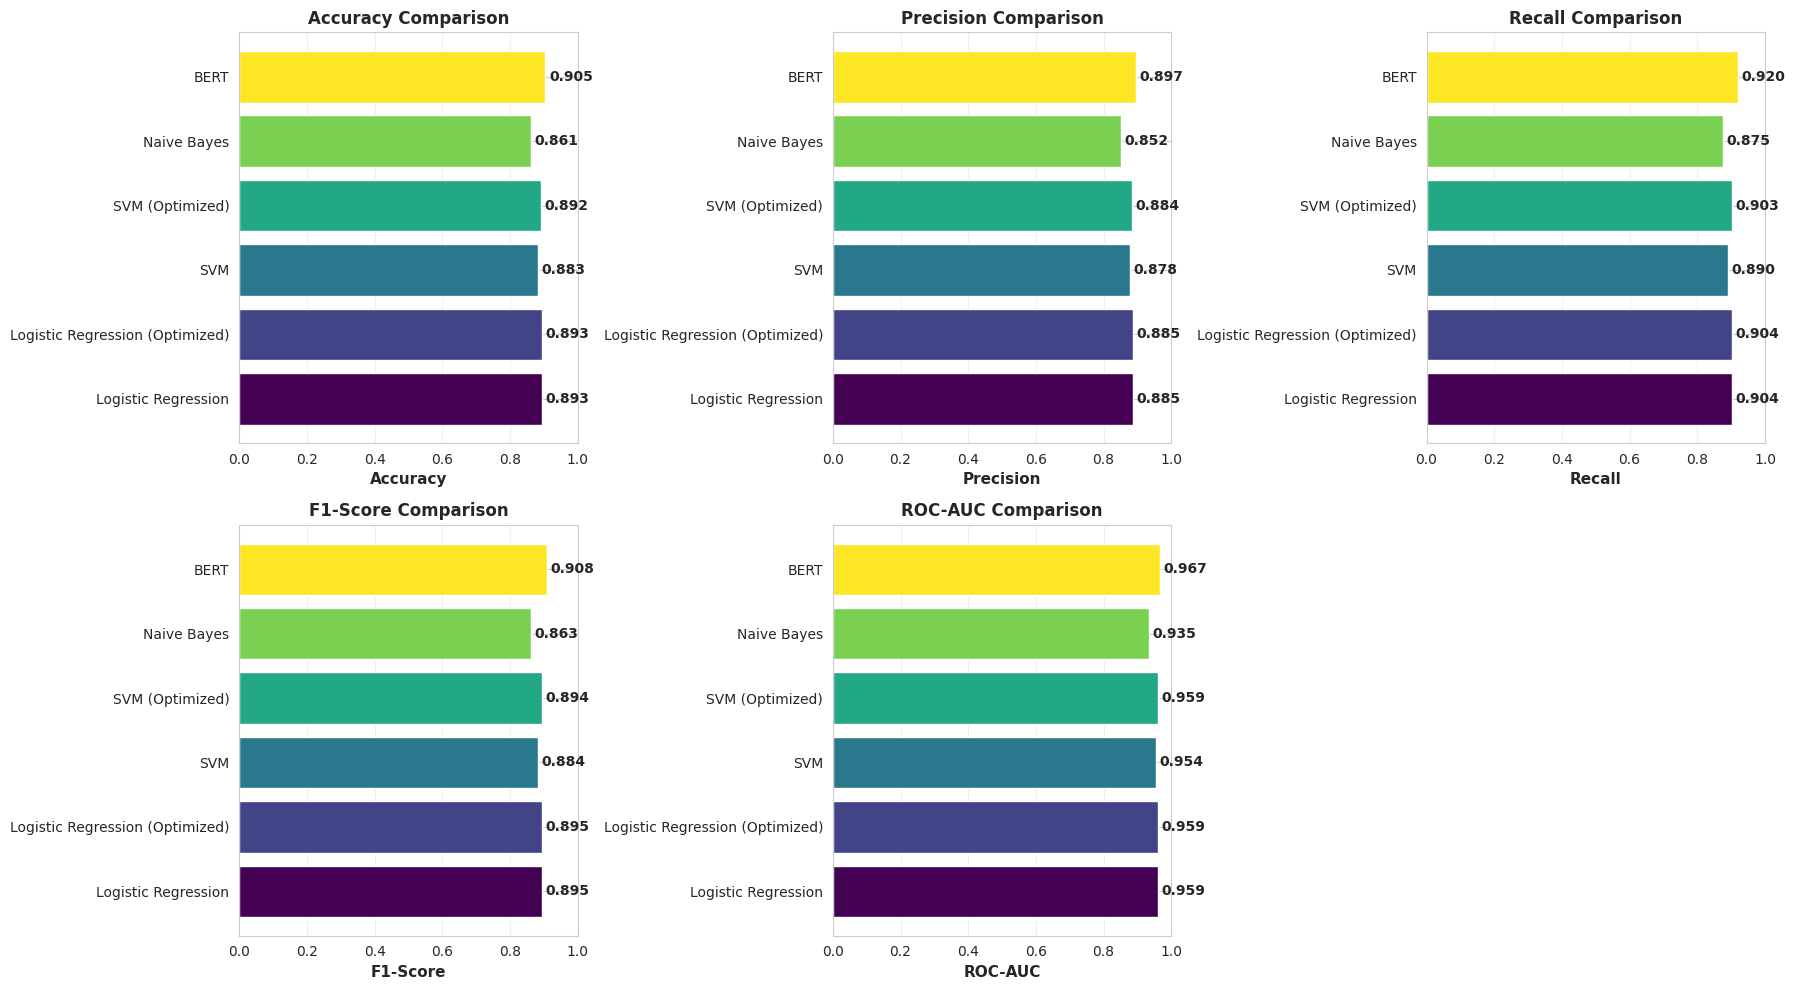

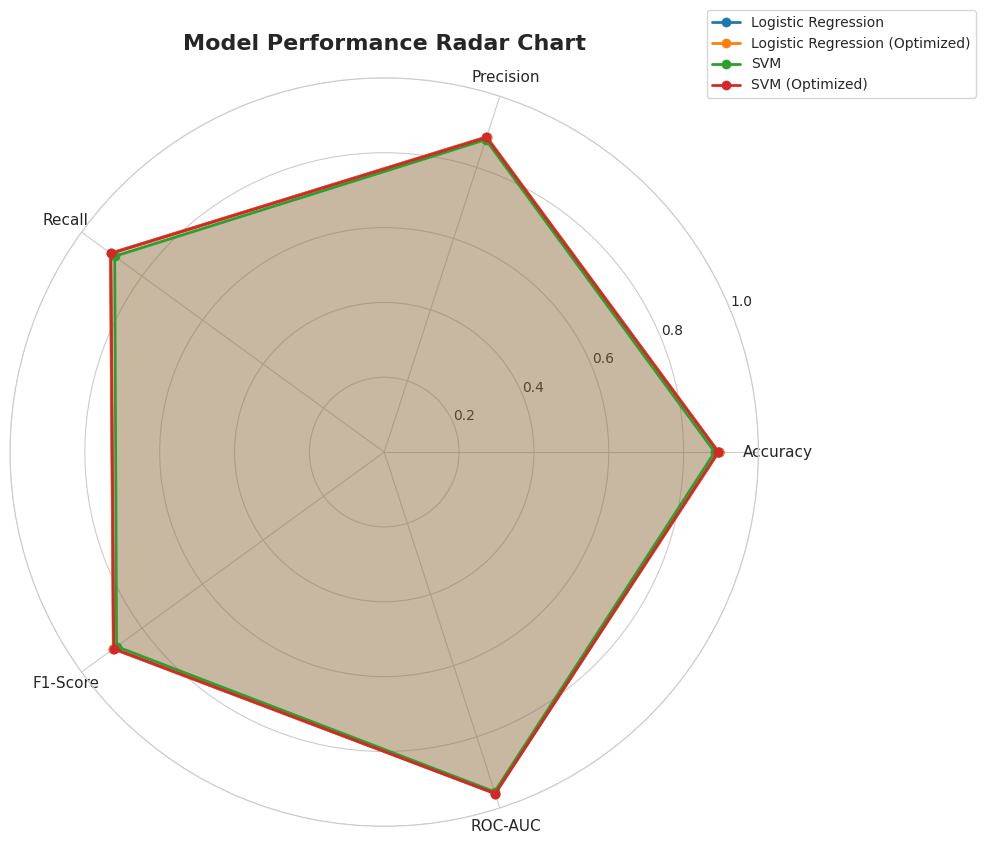

In [9]:
# ============================================================================
# 7. MODEL COMPARISON & EVALUATION
# ============================================================================

print("\n" + "="*80)
print("MODEL COMPARISON & EVALUATION")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
})

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = plt.cm.viridis(np.linspace(0, 1, len(comparison_df)))

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3

    axes[row, col].barh(comparison_df['Model'], comparison_df[metric], color=colors)
    axes[row, col].set_xlabel(metric, fontsize=11, fontweight='bold')
    axes[row, col].set_xlim(0, 1)
    axes[row, col].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].grid(axis='x', alpha=0.3)

    # Add value labels
    for i, v in enumerate(comparison_df[metric]):
        axes[row, col].text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

# Remove empty subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

# Overall performance radar chart
from math import pi

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot each model
for idx, model in enumerate(comparison_df['Model'][:4]):  # Limit to 4 for clarity
    values = comparison_df[comparison_df['Model']==model][categories].values.flatten().tolist()
    values += values[:1]

    ax.plot(angles, values, 'o-', linewidth=2, label=model)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_title('Model Performance Radar Chart', size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()


--- CONFUSION MATRICES ---


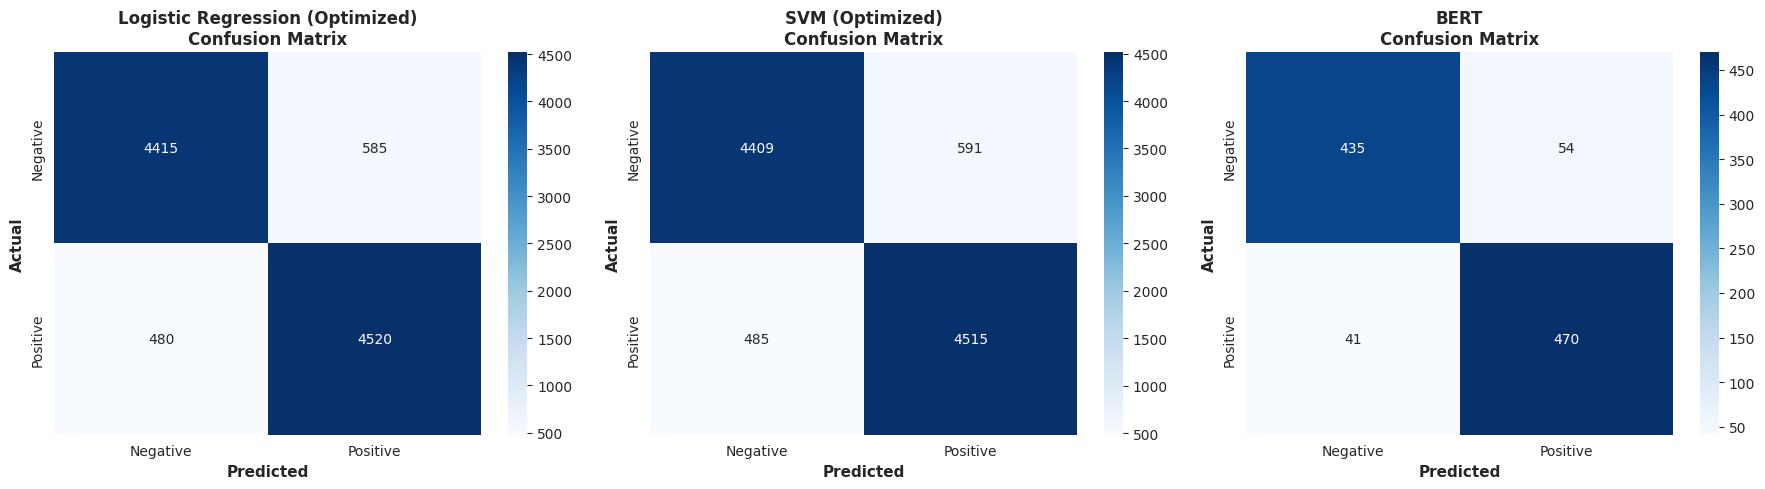


Classification Report: Logistic Regression (Optimized)
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Classification Report: SVM (Optimized)
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Classification Report: BERT
              precision    recall  f1-score   support

    Negative       0.91      0.89      0.90       489
    Positive       0.90      0.92      0.91       511

    accuracy                           0.91      1000
   

In [10]:
# ============================================================================
# 8. CONFUSION MATRICES
# ============================================================================

print("\n--- CONFUSION MATRICES ---")

# Select top 3 models for detailed visualization
top_models = ['Logistic Regression (Optimized)', 'SVM (Optimized)', 'BERT']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_models):
    if model_name not in results:
        continue

    if model_name == 'BERT':
        cm = confusion_matrix(y_test_bert, results[model_name]['predictions'])
    else:
        cm = confusion_matrix(y_test, results[model_name]['predictions'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    axes[idx].set_xlabel('Predicted', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Actual', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{model_name}\nConfusion Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed classification reports
for model_name in top_models:
    if model_name not in results:
        continue

    print(f"\n{'='*60}")
    print(f"Classification Report: {model_name}")
    print('='*60)

    if model_name == 'BERT':
        print(classification_report(y_test_bert, results[model_name]['predictions'],
                                   target_names=['Negative', 'Positive']))
    else:
        print(classification_report(y_test, results[model_name]['predictions'],
                                   target_names=['Negative', 'Positive']))



--- ROC CURVES ---


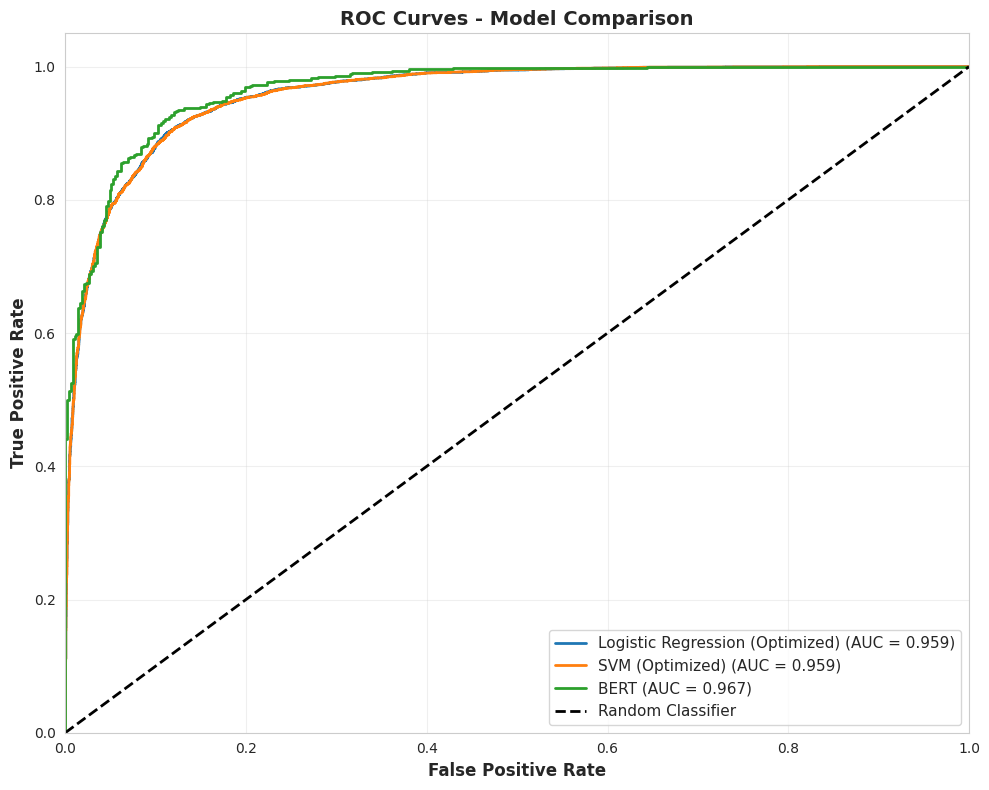

In [11]:
# ============================================================================
# 9. ROC CURVES
# ============================================================================

print("\n--- ROC CURVES ---")

plt.figure(figsize=(10, 8))

for model_name in top_models:
    if model_name not in results:
        continue

    if model_name == 'BERT':
        fpr, tpr, _ = roc_curve(y_test_bert, results[model_name]['probabilities'])
        roc_auc = results[model_name]['roc_auc']
    else:
        fpr, tpr, _ = roc_curve(y_test, results[model_name]['probabilities'])
        roc_auc = results[model_name]['roc_auc']

    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



--- FEATURE IMPORTANCE ANALYSIS ---

Top 20 Features Indicating POSITIVE Sentiment:
  superb: 3.9247
  brilliant: 3.8929
  enjoyable: 3.8403
  fun: 3.8172
  today: 3.8012
  enjoyed: 3.7447
  definitely: 3.6030
  must see: 3.6026
  fantastic: 3.5597
  well worth: 3.5084

Top 20 Features Indicating NEGATIVE Sentiment:
  worst: -8.9239
  awful: -7.4405
  bad: -7.3260
  waste: -6.8029
  boring: -5.9835
  poor: -5.5282
  terrible: -5.4343
  poorly: -5.1113
  nothing: -5.1012
  dull: -5.0046


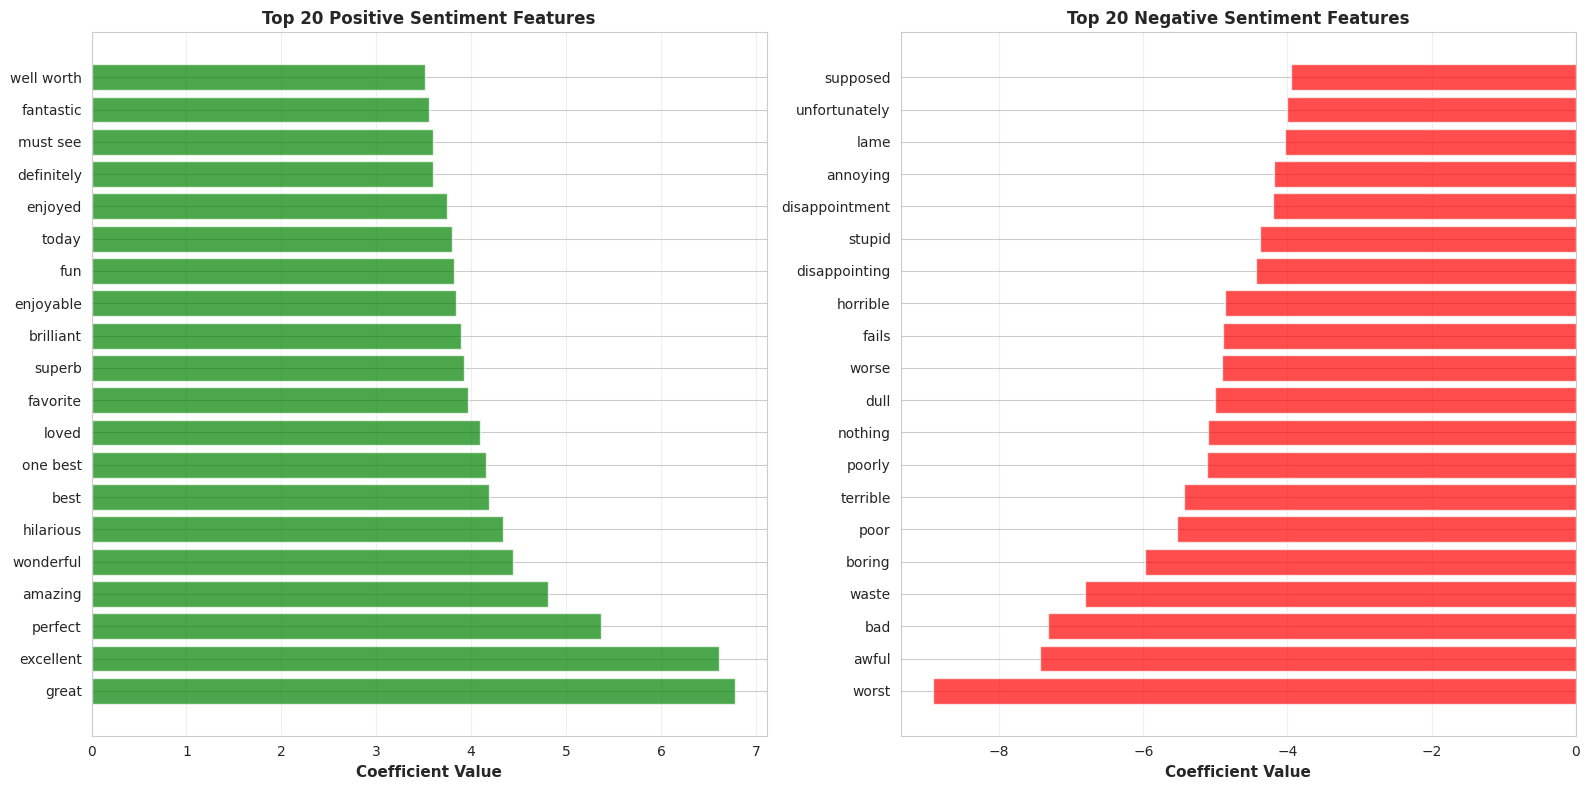

In [12]:
# ============================================================================
# 10. FEATURE IMPORTANCE (LOGISTIC REGRESSION)
# ============================================================================

print("\n--- FEATURE IMPORTANCE ANALYSIS ---")

# Get coefficients from optimized Logistic Regression
lr_best_model = grid_lr.best_estimator_
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_best_model.coef_[0]

# Top positive features (indicate positive sentiment)
top_positive_idx = np.argsort(coefficients)[-20:]
top_positive_features = [(feature_names[i], coefficients[i]) for i in top_positive_idx]

# Top negative features (indicate negative sentiment)
top_negative_idx = np.argsort(coefficients)[:20]
top_negative_features = [(feature_names[i], coefficients[i]) for i in top_negative_idx]

print("\nTop 20 Features Indicating POSITIVE Sentiment:")
for feature, coef in reversed(top_positive_features[:10]):
    print(f"  {feature}: {coef:.4f}")

print("\nTop 20 Features Indicating NEGATIVE Sentiment:")
for feature, coef in top_negative_features[:10]:
    print(f"  {feature}: {coef:.4f}")

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Positive features
pos_words, pos_coefs = zip(*reversed(top_positive_features))
axes[0].barh(pos_words, pos_coefs, color='green', alpha=0.7)
axes[0].set_xlabel('Coefficient Value', fontsize=11, fontweight='bold')
axes[0].set_title('Top 20 Positive Sentiment Features', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Negative features
neg_words, neg_coefs = zip(*top_negative_features)
axes[1].barh(neg_words, neg_coefs, color='red', alpha=0.7)
axes[1].set_xlabel('Coefficient Value', fontsize=11, fontweight='bold')
axes[1].set_title('Top 20 Negative Sentiment Features', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# ============================================================================
# 11. ERROR ANALYSIS
# ============================================================================

print("\n--- ERROR ANALYSIS ---")

# Analyze misclassifications from best model (Optimized Logistic Regression)
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
print(f"\nAnalyzing errors from: {best_model_name}")

if 'BERT' not in best_model_name:
    misclassified_idx = np.where(results[best_model_name]['predictions'] != y_test)[0]

    print(f"\nTotal misclassifications: {len(misclassified_idx)} out of {len(y_test)} ({len(misclassified_idx)/len(y_test)*100:.2f}%)")

    # Show sample misclassifications
    print("\nSample Misclassified Reviews:")
    for i in misclassified_idx[:5]:
        actual = y_test.iloc[i]
        predicted = results[best_model_name]['predictions'][i]
        review_text = X_test.iloc[i][:150]

        print(f"\n{'-'*60}")
        print(f"Review: {review_text}...")
        print(f"Actual: {'Positive' if actual==1 else 'Negative'}")
        print(f"Predicted: {'Positive' if predicted==1 else 'Negative'}")



--- ERROR ANALYSIS ---

Analyzing errors from: BERT


In [14]:
# ============================================================================
# 12. PREDICTION EXAMPLES
# ============================================================================

print("\n" + "="*80)
print("PREDICTION EXAMPLES")
print("="*80)

# Test with custom reviews
test_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot was engaging.",
    "Terrible film. Waste of time and money. Would not recommend to anyone.",
    "It was okay, nothing special but not terrible either.",
    "Best movie I've seen this year! Highly recommended!",
    "Boring and predictable. Very disappointing."
]

print("\nMaking predictions on custom reviews using Optimized Logistic Regression...\n")

for review in test_reviews:
    # Preprocess
    cleaned = clean_text(review)
    processed = preprocess_text(cleaned)

    # Vectorize
    vectorized = tfidf_vectorizer.transform([processed])

    # Predict
    prediction = grid_lr.predict(vectorized)[0]
    probability = grid_lr.predict_proba(vectorized)[0]

    sentiment = "POSITIVE" if prediction == 1 else "NEGATIVE"
    confidence = probability[prediction] * 100

    print(f"Review: \"{review}\"")
    print(f"Sentiment: {sentiment} (Confidence: {confidence:.1f}%)")
    print(f"Probabilities: Negative={probability[0]:.3f}, Positive={probability[1]:.3f}\n")


PREDICTION EXAMPLES

Making predictions on custom reviews using Optimized Logistic Regression...

Review: "This movie was absolutely fantastic! The acting was superb and the plot was engaging."
Sentiment: POSITIVE (Confidence: 91.9%)
Probabilities: Negative=0.081, Positive=0.919

Review: "Terrible film. Waste of time and money. Would not recommend to anyone."
Sentiment: NEGATIVE (Confidence: 99.5%)
Probabilities: Negative=0.995, Positive=0.005

Review: "It was okay, nothing special but not terrible either."
Sentiment: NEGATIVE (Confidence: 99.8%)
Probabilities: Negative=0.998, Positive=0.002

Review: "Best movie I've seen this year! Highly recommended!"
Sentiment: POSITIVE (Confidence: 97.9%)
Probabilities: Negative=0.021, Positive=0.979

Review: "Boring and predictable. Very disappointing."
Sentiment: NEGATIVE (Confidence: 100.0%)
Probabilities: Negative=1.000, Positive=0.000



In [15]:
# ============================================================================
# 13. FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("ANALYSIS COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\n DATASET STATISTICS")
print(f"{'─'*60}")
print(f"  * Total Reviews: {len(df):,}")
print(f"  * Training Samples: {len(X_train):,}")
print(f"  * Test Samples: {len(X_test):,}")
print(f"  * Average Review Length: {df['word_count'].mean():.1f} words")
print(f"  * Sentiment Balance: 50/50 (Balanced)")

print(f"\n🔧 FEATURE ENGINEERING")
print(f"{'─'*60}")
print(f"  * Bag of Words Vocabulary: {len(bow_vectorizer.vocabulary_):,} terms")
print(f"  * TF-IDF Vocabulary: {len(tfidf_vectorizer.vocabulary_):,} terms")
print(f"  * Word2Vec Vocabulary: {len(w2v_model.wv):,} words")
print(f"  * Word2Vec Embedding Dimension: {w2v_model.vector_size}")

print(f"\n MODEL PERFORMANCE")
print(f"{'─'*60}")

# Best model
best_idx = comparison_df['F1-Score'].idxmax()
best_model = comparison_df.loc[best_idx, 'Model']
best_f1 = comparison_df.loc[best_idx, 'F1-Score']
best_accuracy = comparison_df.loc[best_idx, 'Accuracy']
best_roc_auc = comparison_df.loc[best_idx, 'ROC-AUC']

print(f"  * Best Model: {best_model}")
print(f"  * Best F1-Score: {best_f1:.4f}")
print(f"  * Best Accuracy: {best_accuracy:.4f}")
print(f"  * Best ROC-AUC: {best_roc_auc:.4f}")

print(f"\n MODEL RANKINGS (by F1-Score)")
print(f"{'─'*60}")
ranked = comparison_df.sort_values('F1-Score', ascending=False)
for idx, row in ranked.iterrows():
    print(f"  {idx+1}. {row['Model']}: F1={row['F1-Score']:.4f}, Accuracy={row['Accuracy']:.4f}")

print(f"\n All analyses completed successfully!")
print(f"{'='*80}\n")

# Save results
print("Saving results...")
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("Results saved to 'model_comparison_results.csv'")

print("\n Sentiment Analysis Pipeline Complete!")
print("="*80)


ANALYSIS COMPLETE - FINAL SUMMARY

 DATASET STATISTICS
────────────────────────────────────────────────────────────
  * Total Reviews: 50,000
  * Training Samples: 40,000
  * Test Samples: 10,000
  * Average Review Length: 231.2 words
  * Sentiment Balance: 50/50 (Balanced)

🔧 FEATURE ENGINEERING
────────────────────────────────────────────────────────────
  * Bag of Words Vocabulary: 5,000 terms
  * TF-IDF Vocabulary: 5,000 terms
  * Word2Vec Vocabulary: 34,378 words
  * Word2Vec Embedding Dimension: 100

 MODEL PERFORMANCE
────────────────────────────────────────────────────────────
  * Best Model: BERT
  * Best F1-Score: 0.9082
  * Best Accuracy: 0.9050
  * Best ROC-AUC: 0.9669

 MODEL RANKINGS (by F1-Score)
────────────────────────────────────────────────────────────
  6. BERT: F1=0.9082, Accuracy=0.9050
  1. Logistic Regression: F1=0.8946, Accuracy=0.8935
  2. Logistic Regression (Optimized): F1=0.8946, Accuracy=0.8935
  4. SVM (Optimized): F1=0.8935, Accuracy=0.8924
  3. SVM: F1